In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier


In [5]:
telco = pd.read_csv("Telco-Customer-Churn.csv")

In [6]:
telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
telco.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [11]:
telco['TotalCharges'] = pd.to_numeric(telco['TotalCharges'], errors='coerce')

telco.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [12]:
mean_charges = telco['TotalCharges'].mean()
telco['TotalCharges'] = telco['TotalCharges'].fillna(mean_charges)

In [13]:
telco.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [17]:
telco.drop("customerID", axis = 1, inplace = True)


<class 'KeyError'>: "['customerID'] not found in axis"

In [18]:
for col in telco.select_dtypes(include=['object', 'category']).columns:
    print(f"\nColumn: {col}")
    print(telco[col].value_counts(dropna=False))


Column: gender
gender
Male      3555
Female    3488
Name: count, dtype: int64

Column: Partner
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Column: Dependents
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

Column: PhoneService
PhoneService
Yes    6361
No      682
Name: count, dtype: int64

Column: MultipleLines
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

Column: InternetService
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

Column: OnlineSecurity
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

Column: OnlineBackup
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

Column: DeviceProtection
DeviceProtection
No                     3095
Yes                    2422
No internet service   

In [19]:
X = telco.drop(columns='Churn')
y = telco['Churn'].map({'No': 0, 'Yes': 1})  # Binary encoding for target

In [20]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()

In [24]:

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)

In [33]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])


In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

pipeline.fit(X_train, y_train)


/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:03:12] WARNING: /root/repo/packages/xgboost/build/xgboost-2.1.2/cpp_src/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSuppo...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1294
           1       0.61      0.49      0.55       467

    accuracy                           0.78      1761
   macro avg       0.72      0.69      0.70      1761
weighted avg       0.77      0.78      0.78      1761



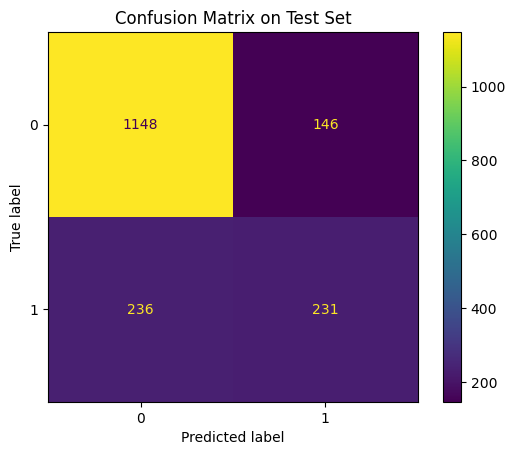

In [41]:
y_pred = pipeline.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred))


ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix on Test Set")
plt.show()


In [37]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(pipeline, X, y, cv=5)
print("Average CV Accuracy:", cv_scores.mean())

/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:09:22] WARNING: /root/repo/packages/xgboost/build/xgboost-2.1.2/cpp_src/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:09:22] WARNING: /root/repo/packages/xgboost/build/xgboost-2.1.2/cpp_src/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:09:22] WARNING: /root/repo/packages/xgboost/build/xgboost-2.1.2/cpp_src/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:09:22] WARNING: /root/repo/packages/xgboost/build/xgboost-2.1.2/cpp_src/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/lib/python3

Average CV Accuracy: 0.779500088715401


/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:41:00] WARNING: /root/repo/packages/xgboost/build/xgboost-2.1.2/cpp_src/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


WITH scale_pos_weight=2.77:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1294
           1       0.54      0.66      0.60       467

    accuracy                           0.76      1761
   macro avg       0.71      0.73      0.71      1761
weighted avg       0.78      0.76      0.77      1761



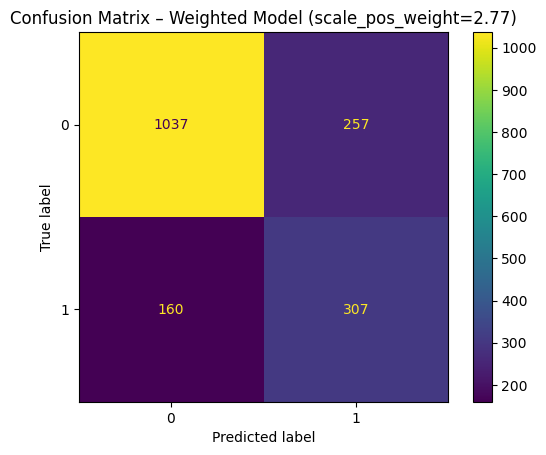

In [45]:
pipeline_weighted = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                            scale_pos_weight=2.77, random_state=42))
])

pipeline_weighted.fit(X_train, y_train)
y_pred_weighted = pipeline_weighted.predict(X_test)

print("WITH scale_pos_weight=2.77:")
print(classification_report(y_test, y_pred_weighted))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_weighted)
plt.title("Confusion Matrix – Weighted Model (scale_pos_weight=2.77)")
plt.show()


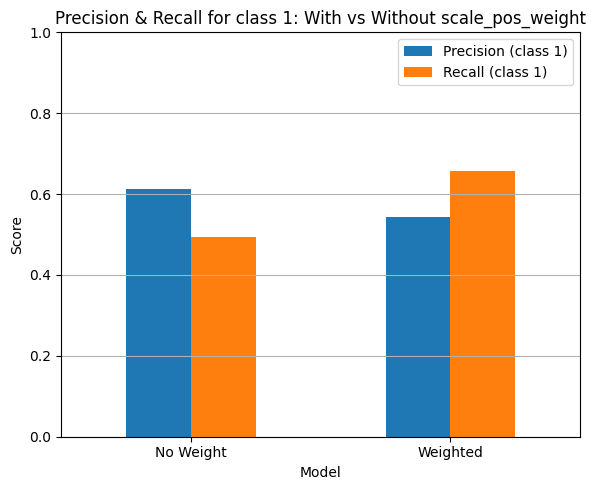

In [49]:
from sklearn.metrics import precision_score, recall_score

metrics_comparison = pd.DataFrame({
    'Model': ['No Weight', 'Weighted'],
    'Precision (class 1)': [
        precision_score(y_test, y_pred, pos_label=1),
        precision_score(y_test, y_pred_weighted, pos_label=1)
    ],
    'Recall (class 1)': [
        recall_score(y_test, y_pred, pos_label=1),
        recall_score(y_test, y_pred_weighted, pos_label=1)
    ]
})

metrics_comparison.set_index('Model').plot(kind='bar', figsize=(6, 5))
plt.title("Precision & Recall for class 1: With vs Without scale_pos_weight")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


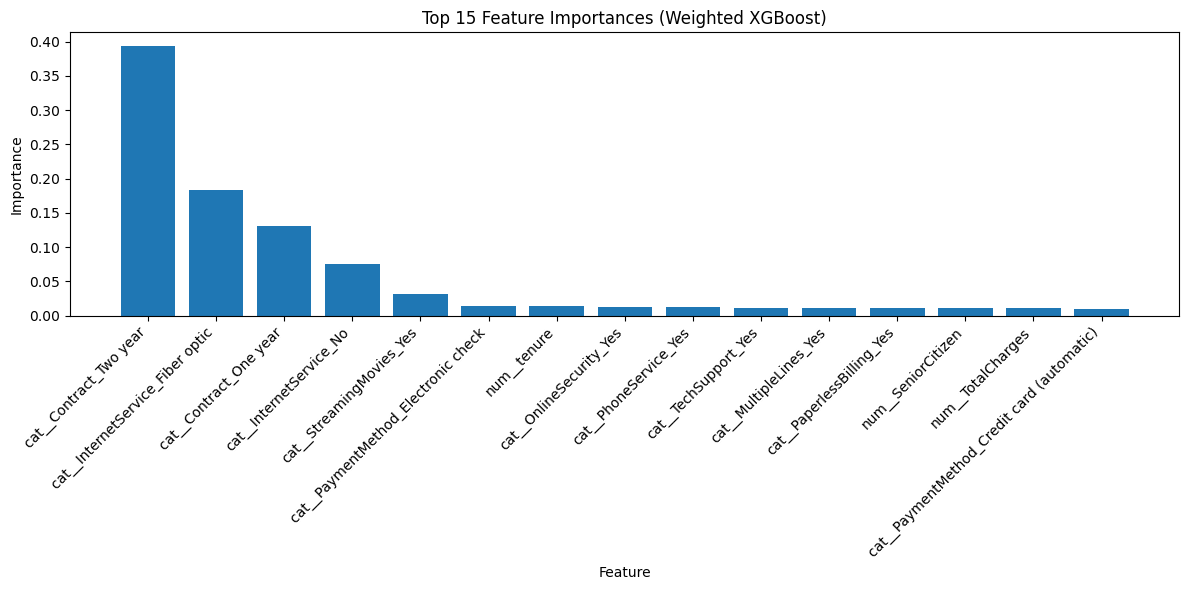

In [52]:
model = pipeline_weighted.named_steps['model']
feature_names = pipeline_weighted.named_steps['preprocessor'].get_feature_names_out()

importances = model.feature_importances_

feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(12, 6))
plt.bar(feat_df['Feature'][:15], feat_df['Importance'][:15])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Top 15 Feature Importances (Weighted XGBoost)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


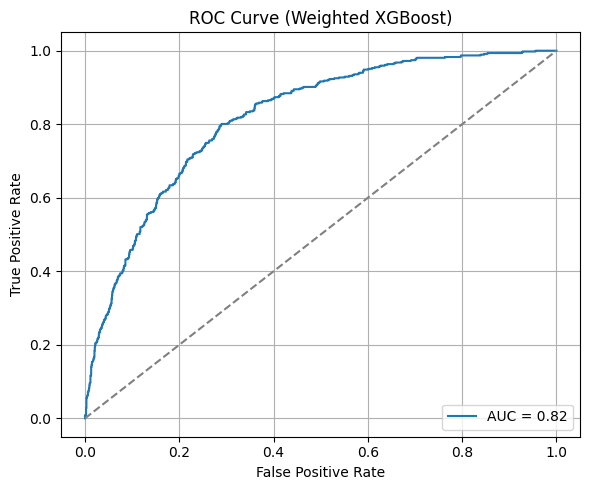

In [51]:
from sklearn.metrics import roc_curve, roc_auc_score


y_proba = pipeline_weighted.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)


plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Weighted XGBoost)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
